In [1]:
# make the directories needed for the project
import pathlib

def mkdir(path):
    pathlib.Path(path).mkdir(exist_ok=True)

mkdir("metrics")
mkdir("models")
mkdir("db")
mkdir("cache")

In [2]:
import os
from config import config

CODA_DLL_PATH = config["preprocessing"]["coda_dll_path"]
H5_FILE = config["main"]["h5_file"]
CLASSES = config.get_classes()
IMG_SIZE = int(config["main"]["img_size"])

os.add_dll_directory(
    CODA_DLL_PATH
)  # https://github.com/tensorflow/tensorflow/issues/48868#issuecomment-841396124


import pandas as pd
import matplotlib.pyplot as plt
import preprocessing
from plogging import logger

x_train, x_test, y_train, y_test = preprocessing.create_dataset(H5_FILE, test_size=0.8, cache=True)
logger.info(y_train.value_counts())


[18:43:30] Create dataset started [h5_file=SynthText.h5]
[18:43:32] Collected db from catche [cache_path=cache/__base64__.h5]
[18:43:32] Function 'create_dataset' executed in 2.0202s
[18:43:32] Ubuntu Mono    966
Roboto         876
Raleway        864
Alex Brush     855
Russo One      849
Open Sans      713
Michroma       516
Name: font, dtype: int64


Uncomment the cell below to import a dataset rather than creating one

In [3]:

# import pandas as pd
# import numpy as np
# from plogging import logger
# import os
# from config import config

# CODA_DLL_PATH = config["preprocessing"]["coda_dll_path"]
# H5_FILE = config["main"]["h5_file"]
# CLASSES = config.get_classes()
# IMG_SIZE = int(config["main"]["img_size"])

# os.add_dll_directory(
#     CODA_DLL_PATH
# )  # https://github.com/tensorflow/tensorflow/issues/48868#issuecomment-841396124

# def extract(file):
#     data = pd.read_hdf(file, key="db")
#     Y = data["font"]
#     X = data.drop(columns=["font"])
#     return X,Y


# TRAIN_FILE = "db/prep_28197r_train_augment_image_v5_035.h5"
# x_train, y_train_ = extract(TRAIN_FILE)
# # find corresponding test data

# TEST_FILE = TRAIN_FILE.replace("train", "test")
# x_test, y_test_ = extract(TEST_FILE)


# logger.info(y_train_.value_counts())

Uncomment to code below to import generated data

In [4]:
# GENERATED_H5 = r"D:\results\SynthText_2000.h5"
# x_generated,y_generated = preprocessing.create_dataset(GENERATED_H5, cache=False, save=True, no_split=True)

import pandas as pd

H5_FILES = ["db/prep_81975r_unsplit_rest_2000.h5", "db/prep_78360r_unsplit_2000.h5"] 

for h5_file in H5_FILES:
    df = pd.read_hdf(h5_file)
    y_generated = df["font"]
    x_generated = df.drop(columns=["font"])

    x_train = pd.concat([x_train, x_generated])
    y_train = pd.concat([y_train, y_generated])

logger.info(y_train.value_counts())

[18:43:42] Ubuntu Mono    29357
Raleway        25781
Russo One      23774
Alex Brush     23439
Roboto         22980
Open Sans      22508
Michroma       18135
Name: font, dtype: int64


In [5]:
# move y to categorical
import numpy as np
import tensorflow as tf

to_index = lambda s : CLASSES.index(s)
to_cat = lambda i : CAT_CLASSES[i]

ty_train = np.array(y_train.apply(to_index))
ty_test = np.array(y_test.apply(to_index))

CAT_CLASSES = tf.keras.utils.to_categorical(np.unique(ty_test))

y_train = to_cat(ty_train)
y_test = to_cat(ty_test)


In [6]:
x_test_norm = np.array(x_test["img"].to_list(), dtype=np.float32)/255
x_train = np.array(x_train["img"].to_list(), dtype=np.float32)

In [7]:
import metrics
import vote

def results_to_csv(x_test, y):
    df = x_test.copy()
    df["pred"] = np.argmax(y, axis=1)

    for klass in CLASSES:
        x_test[klass] = 0 # add classes column
    df["pred"] = df["pred"].apply(lambda idx : CLASSES[idx]) # back to label
    for index, row in df.iterrows():
        df.at[index, row.pred] = 1

    df = df.drop(columns=["pred", "img", "img_norm"], errors="ignore") # TODO: remove img_norm later 
    df = df.rename(columns={"img_name": "img"})
    df.to_csv("results.csv")


def log_stats(y_test, y_pred, save=True, file_path="stats"):
    recall = tf.keras.metrics.Recall()
    recall.update_state(y_test, y_pred)
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_test, y_pred)
    auc = tf.keras.metrics.AUC()
    auc.update_state(y_test, y_pred)
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(y_test, y_pred)

    print(f"Accuracy: {acc.result().numpy()}")
    print(f"Recall: {recall.result().numpy()}")
    print(f"Precision: {precision.result().numpy()}")
    print(f"AUC: {auc.result().numpy()}")
    
    if save:
        with open(file_path, "w") as f:
            print(f"Accuracy: {acc.result().numpy()}", file=f)
            print(f"Recall: {recall.result().numpy()}",file=f )
            print(f"Precision: {precision.result().numpy()}",file=f)
            print(f"AUC: {auc.result().numpy()}", file=f)

def eval_model(history,x_test, y_test, y_pred, classes, save=True):
    logger.info("Model stats:")
    metrics.plot_acc(history, save=save)
    metrics.plot_loss(history, save=save)
    
    
    log_stats(y_test, y_pred, save=save, file_path="metrics/stats_before_votes.txt")
    metrics.plot_roc(y_test, y_pred, CLASSES, zoom=False, save=save)
    metrics.plot_confusion_matrix(y_test, y_pred, classes, save=save)
    
    logger.info("After votes:")
    y_pred_ = vote.vote(x_test, y_pred)
    log_stats(y_test, y_pred_, save=save, file_path="metrics/stats_aftervotes.txt")
    metrics.plot_roc(y_test, y_pred_, CLASSES, zoom=False, save=save)
    metrics.plot_confusion_matrix(y_test, y_pred_, classes, save=save)
    return y_pred_





In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

optimizer = Adam(learning_rate=0.001)
optimizer = RMSprop(0.0001)

metrics_ = ["accuracy"]

logger.info(f"Train samples size [x_train={len(x_train)}, x_test={len(x_test_norm)}]")

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7), tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3, verbose=1,factor=0.5,min_lr=0.00001)]

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        zca_whitening=False,  # apply ZCA whitening
        zoom_range = 0.3, # Randomly zoom image 
        width_shift_range=0.05,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.05,  # randomly shift images vertically (fraction of total height)
        rotation_range=10,
        shear_range=10,
        brightness_range=(0.7, 1),
        validation_split=0.1,
        rescale=1./255
        )

model = Sequential([
    tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling="max"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])


train_gen = datagen.flow(x_train, y_train, batch_size=32, subset='training')
test_gen = datagen.flow(x_train, y_train, batch_size=8, subset='validation')

model.compile(optimizer=optimizer, metrics=metrics_, loss="categorical_crossentropy")

model.summary()
history = model.fit(train_gen, epochs=100, validation_data=test_gen, verbose=1, callbacks=callbacks, steps_per_epoch=train_gen.n//train_gen.batch_size, validation_steps=test_gen.n//test_gen.batch_size)


[18:44:11] Train samples size [x_train=165974, x_test=22558]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 batch_normalization_1 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                             

[15:30:31] Model stats:


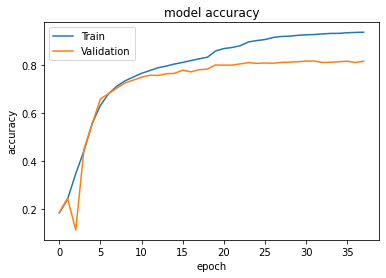

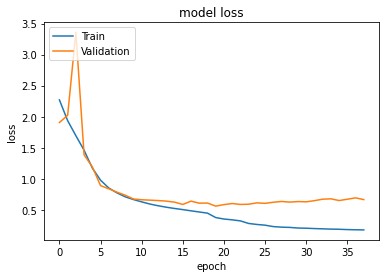

Accuracy: 0.7954162359237671
Recall: 0.7807430028915405
Precision: 0.823106050491333
AUC: 0.9588384628295898


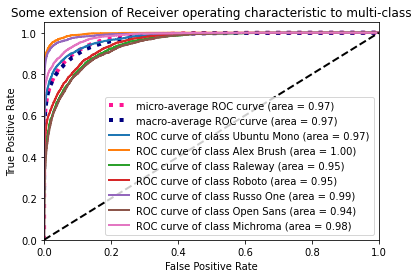

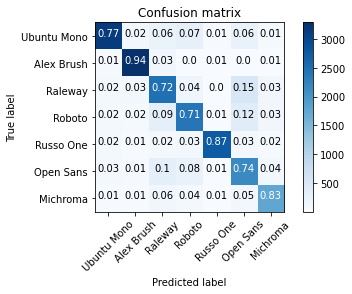

[15:30:39] After votes:
Accuracy: 0.8411650061607361
Recall: 0.8411650061607361
Precision: 0.8411650061607361
AUC: 0.907346248626709


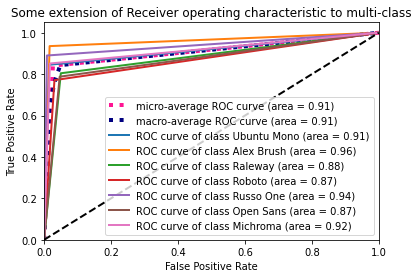

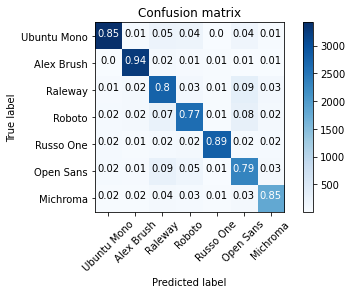

In [ ]:
y_pred = model.predict(x_test_norm)
y_pred_after_votes = eval_model(history, x_test ,y_test, y_pred, CLASSES, save=True)
results_to_csv(x_test, y_pred_after_votes)

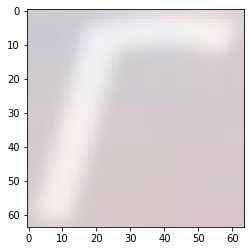

[15:31:01] Char: r
[15:31:01] Image: hill_145.jpg_0
[15:31:01] Predicted label: Open Sans
[15:31:01] True label: Ubuntu Mono


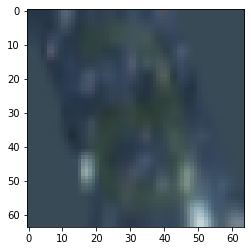

[15:31:01] Char: a
[15:31:01] Image: hubble_97.jpg_0
[15:31:01] Predicted label: Raleway
[15:31:01] True label: Ubuntu Mono


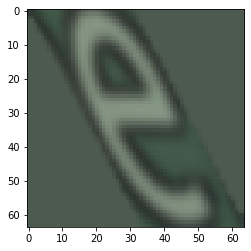

[15:31:01] Char: e
[15:31:01] Image: kerala_38.jpg_0
[15:31:01] Predicted label: Roboto
[15:31:01] True label: Ubuntu Mono


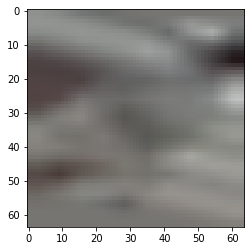

[15:31:02] Char: :
[15:31:02] Image: rain_82.jpg_0
[15:31:02] Predicted label: Russo One
[15:31:02] True label: Raleway


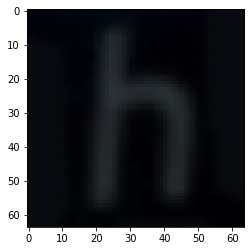

[15:31:02] Char: h
[15:31:02] Image: night_14.jpg_0
[15:31:02] Predicted label: Roboto
[15:31:02] True label: Ubuntu Mono


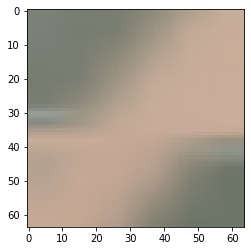

[15:31:02] Char: :
[15:31:02] Image: woollens_43.jpg_0
[15:31:02] Predicted label: Raleway
[15:31:02] True label: Alex Brush


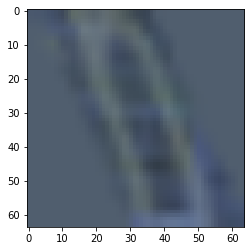

[15:31:02] Char: n
[15:31:02] Image: city+skyline_55.jpg_0
[15:31:02] Predicted label: Raleway
[15:31:02] True label: Roboto


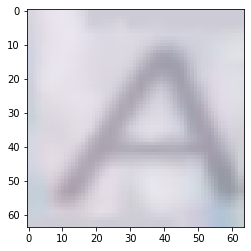

[15:31:02] Char: A
[15:31:02] Image: hiking_50.jpg_0
[15:31:02] Predicted label: Open Sans
[15:31:02] True label: Roboto


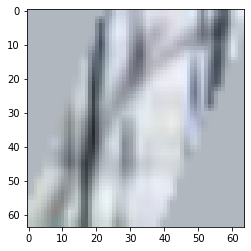

[15:31:02] Char: r
[15:31:02] Image: zoo_130.jpg_0
[15:31:02] Predicted label: Michroma
[15:31:02] True label: Raleway


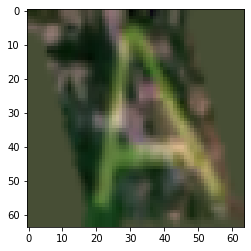

[15:31:02] Char: A
[15:31:02] Image: bay+area_146.jpg_0
[15:31:02] Predicted label: Alex Brush
[15:31:02] True label: Michroma


In [ ]:
# plots a sample of model errors
import matplotlib.pyplot as plt

predict = np.argmax(y_pred_after_votes, axis=1)
true_y_val = np.argmax(y_test, axis=1)
errors = np.flatnonzero(predict != true_y_val)

for i in np.random.choice(errors, 10):
    x_ = x_test.iloc[i, :]
    plt.imshow(x_["img"], cmap="gray")
    plt.show()
    logger.info("Char: {}".format(x_["char"]))
    logger.info("Image: {}".format(x_["img_name"]))
    logger.info("Predicted label: {}".format(CLASSES[predict[i]]))
    logger.info("True label: {}".format(CLASSES[true_y_val[i]]))

In [ ]:

# MODEL_NAME = "model_1201_84_aftervotes"
# model.save(f"models/{MODEL_NAME}")

INFO:tensorflow:Assets written to: models/model_1201_84_aftervotes\assets
